<a href="https://colab.research.google.com/github/Rebecca38/gh-repo-clone-khaouitiabdelhakim-Microsoft-Office-With-Activation-For-Lifetime/blob/main/Results_image_classification_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Model

In [1]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from tensorflow import data as tf_data

## Data Exploration

Load the data: the Cats vs Dogs dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  91.6M      0  0:00:08  0:00:08 --:--:--  109M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [ ]:
import cv2

# Load the image
image_path = '/content/PetImages/Cat/1001.jpg'
image = cv2.imread(image_path)

# Get dimensions
height, width, channels = image.shape

# Print dimensions
print(f"Width: {width}, Height: {height}, Channels: {channels}")


Width: 336, Height: 500, Channels: 3


Generate a Dataset

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Visualise the images

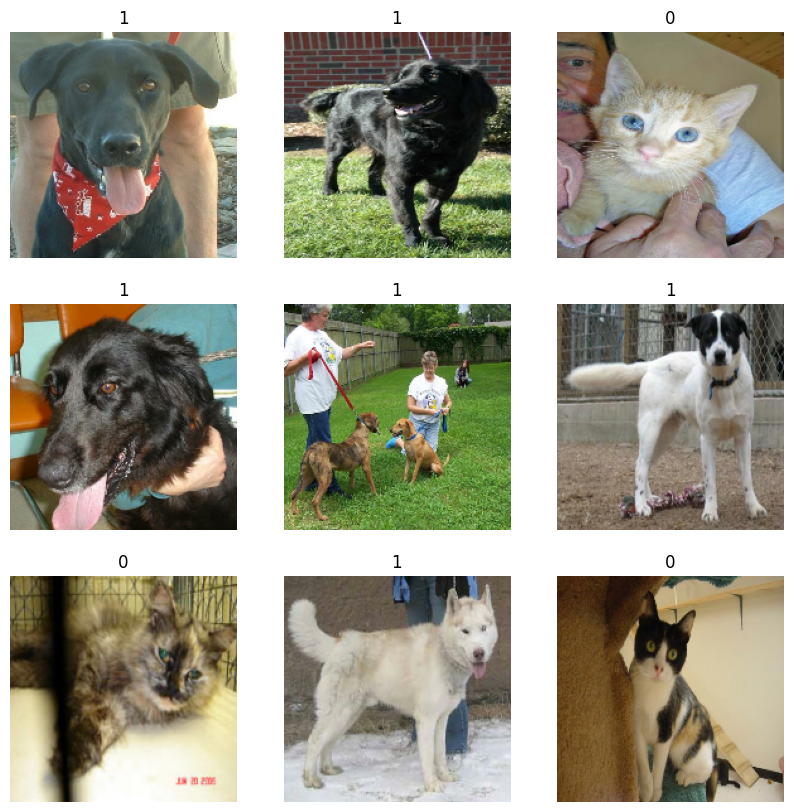

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

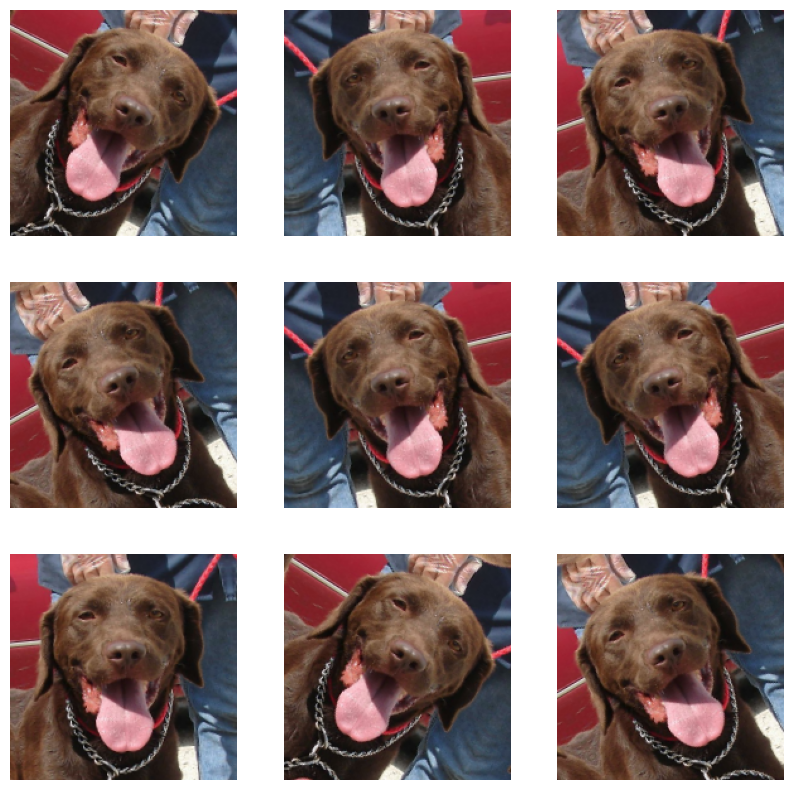

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

##Two options to preprocess the data


In [ ]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

## Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:


In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

### Configure the dataset for performance
# New Section

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### **Build a model**

```
# This is formatted as code
```



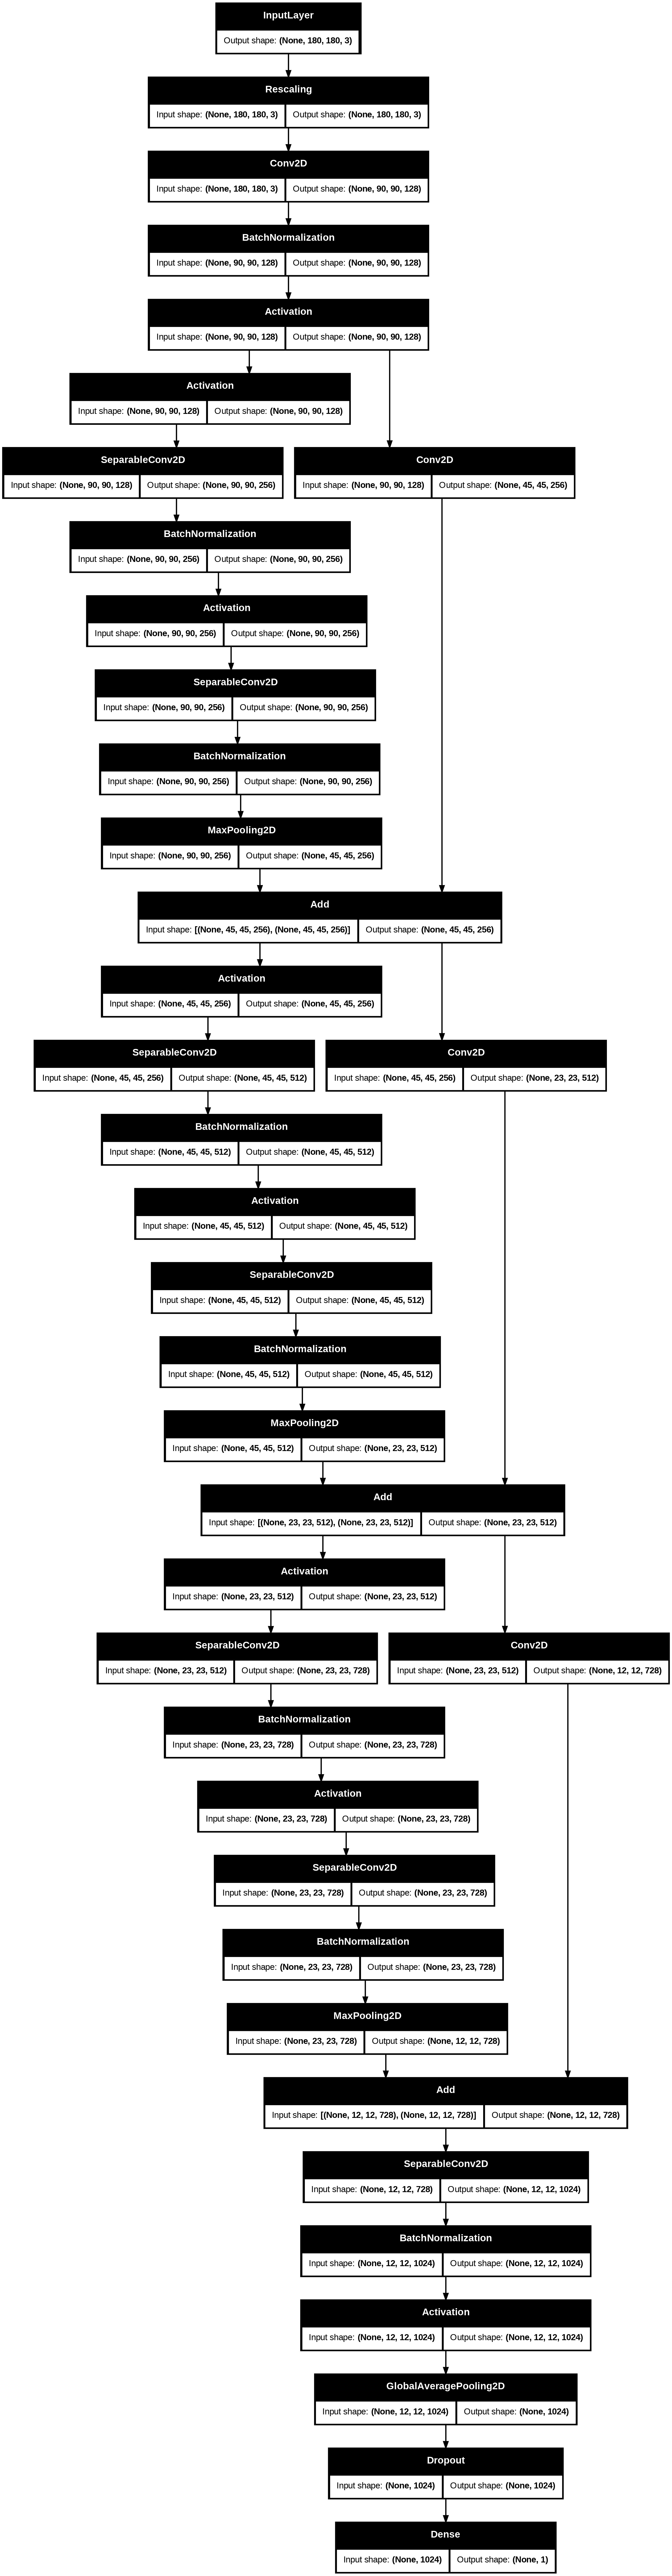

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(image_size)

#### Train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - acc: 0.6284 - loss: 0.6398 - val_acc: 0.4957 - val_loss: 0.6973
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - acc: 0.7474 - loss: 0.4940 - val_acc: 0.4957 - val_loss: 0.6941
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - acc: 0.8200 - loss: 0.3861 - val_acc: 0.5444 - val_loss: 0.7058
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - acc: 0.8497 - loss: 0.3281 - val_acc: 0.4957 - val_loss: 0.9449
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - acc: 0.8729 - loss: 0.2816 - val_acc: 0.8193 - val_loss: 0.3399
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - acc: 0.8954 - loss: 0.2493 - val_acc: 0.8300 - val_loss: 0.3262
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - acc: 0.8967 - loss: 0.2277 - val_acc: 0.8853 - val_loss: 0.2458
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - acc: 0.9088 - loss: 0.2058 - val_acc: 0.9097 - val_loss: 0.2785
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/